In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM

### Cargar el Dataset

In [2]:
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dF = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

df_A = dF.loc[dF['period']=='train_a']
df_A = df_A.dropna()

### Preprocesamiento

Partiendo de la hipótesis de que el dataset no contiene valores anómalos, se deben ingresar manualmente.
Para esto, se selecciona la variable "bt" que corresponde con la magnitud total del campo magnético interplanetario [nT].

Se define la variable "anomaly_factor" para determinar la cantidad de valores anómalos a incorporar al dataset.

Al dataset se le agrega un feature "class" cuyo valor será 1 si el registro contiene un valor anómalo y 0 si el valor del registro es el original del dataset.

In [3]:
features = ['bt']
anomaly_factor = 0.17
# Crear una copia del DataFrame para no modificar el original
df_new = df_A.copy()

for a in features:
  num_replace = int(df_A[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(df_A.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  #new_values = np.random.uniform(-90, 1050, size=num_replace)
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new.loc[df_A[a] != df_new[a], 'class'] = 1
  df_new.loc[df_A[a] == df_new[a], 'class'] = 0

In [4]:
df_new

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source,class
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,12.293715,1.53,383.92,110237.0,ac,1.0
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.830000,1.69,381.79,123825.0,ac,0.0
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.770000,1.97,389.11,82548.0,ac,0.0
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.740000,1.97,389.11,82548.0,ac,0.0
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.650000,1.77,384.26,94269.0,ac,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729434,train_a,1200 days 23:54:00,-3.62,3.25,-1.51,-17.23,138.15,-3.62,3.56,-0.39,-4.33,135.51,5.090000,5.50,338.48,45889.0,ac,0.0
1729435,train_a,1200 days 23:55:00,-4.07,3.06,-1.54,-16.78,143.08,-4.07,3.39,-0.47,-5.09,140.20,5.320000,6.05,339.02,43507.0,ac,0.0
1729436,train_a,1200 days 23:56:00,-3.35,3.40,-1.43,-16.63,134.59,-3.35,3.68,-0.26,-2.98,132.32,4.980000,5.37,338.51,42298.0,ac,0.0
1729437,train_a,1200 days 23:57:00,-3.27,3.42,-1.29,-15.22,133.66,-3.27,3.65,-0.12,-1.42,131.78,4.900000,5.18,342.72,38547.0,ac,0.0


#### Verificación de registros con anomalidades introducidas

Se divide el Dataset en Train y Test

In [5]:
train_data = df_new.sample(frac=0.8, random_state=0)
test_data = df_new.drop(train_data.index)

In [6]:
train_timedelta = train_data[['timedelta']]
test_timedelta = test_data[['timedelta']]

Se eliminan los features que no se tendran en cuenta en el entrenamiento del modelo

In [7]:
y = test_data['class']
y_full = test_data
train_data = train_data.drop(["timedelta", "period", "source", 'class'], axis=1)
test_data = test_data.drop(["timedelta", "period", "source", 'class'], axis=1)

Normalización del dataset

In [8]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [9]:
#train_data = np.concatenate([train_timedelta,train_data], axis=1)
#test_data = np.concatenate([test_timedelta,test_data], axis=1)

In [10]:
train_data_LSTM = train_data.reshape(train_data.shape[0],1,train_data.shape[1])
test_data_LSTM = test_data.reshape(test_data.shape[0],1,test_data.shape[1])
#train_data_LSTM.shape
#test_data_LSTM.shape

## Modelos

### LSTM Autoencoder

Creación del modelo

In [11]:
input_dim = train_data_LSTM.shape[2]
timesteps = 1

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

Entrenamiento del LSTM Autoencoder

In [12]:
autoencoder.fit(train_data_LSTM, train_data_LSTM, epochs=10, batch_size=320, validation_split=0.1)

Epoch 1/10
3138/3138 [==============================] - 26s 6ms/step - loss: 0.1695 - val_loss: 0.0287
Epoch 2/10
3138/3138 [==============================] - 18s 6ms/step - loss: 0.0185 - val_loss: 0.0101
Epoch 3/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 5/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/10
3138/3138 [==============================] - 18s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10
3138/3138 [==============================] - 18s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/10
3138/3138 [==============================] - 19s 6ms/step - l

In [13]:
predictions_LSTM = autoencoder.predict(test_data_LSTM)

8716/8716 [==============================] - 14s 2ms/step


Evaluación del modelo LSTM Autoencoder

Se comparan las predicciones con los valores reales de "class" para generar una matriz de confusión para evaluar el modelo

In [14]:
threshold_LSTM = 0.01
predictions_LSTM[predictions_LSTM >= threshold_LSTM] = 1
predictions_LSTM[predictions_LSTM < threshold_LSTM] = 0

In [15]:
predictions_LSTM = predictions_LSTM.reshape(predictions_LSTM.shape[0], predictions_LSTM.shape[2])
test_data = test_data.reshape(test_data_LSTM.shape[0], test_data_LSTM.shape[2])
y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_LSTM[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0    1.0
Actual                  
0.0        215630  16024
1.0          7948  39309


In [16]:
pd_predictions_LSTM = pd.DataFrame(predictions_LSTM)
column_10 = predictions_LSTM[:, 10]
is_one_LSTM = column_10 ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_LSTM = np.where(is_one_LSTM, 1, 0)

In [17]:
has_ones_LSTM_pd = pd.DataFrame(has_ones_LSTM, columns=['class'])
count = (has_ones_LSTM_pd['class'] == 1).sum()
count1 = (has_ones_LSTM_pd['class'] == 0).sum()
print(f'El número de anomalias es {count} y {count1} son valores normales')

El número de anomalias es 55333 y 223578 son valores normales


In [18]:
new_column_LSTM = has_ones_LSTM
# Agregar la nueva columna al final del ndarray original
predictions_class_LSTM = np.hstack((predictions_LSTM, new_column_LSTM.reshape(-1, 1)))

In [19]:
new_column_LSTM_df = pd.DataFrame(new_column_LSTM, columns =['class'])
count3 = (new_column_LSTM_df['class'] == True).sum()
count4 = (new_column_LSTM_df['class'] == False).sum()
print(f'El número de anomalias es {count3} y {count4} son valores normales')

El número de anomalias es 55333 y 223578 son valores normales


In [20]:
pd_predictions_LSTM = pd.DataFrame(predictions_class_LSTM)

In [21]:
pd_test_data = pd.DataFrame(test_data)

In [22]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_LSTM[:,14], y))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    223578
         1.0       0.83      0.71      0.77     55333

    accuracy                           0.91    278911
   macro avg       0.88      0.84      0.86    278911
weighted avg       0.91      0.91      0.91    278911



In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

In [24]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47257


In [25]:
predictions_class_LSTM_pd  = pd.DataFrame(predictions_class_LSTM, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_LSTM_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 55333


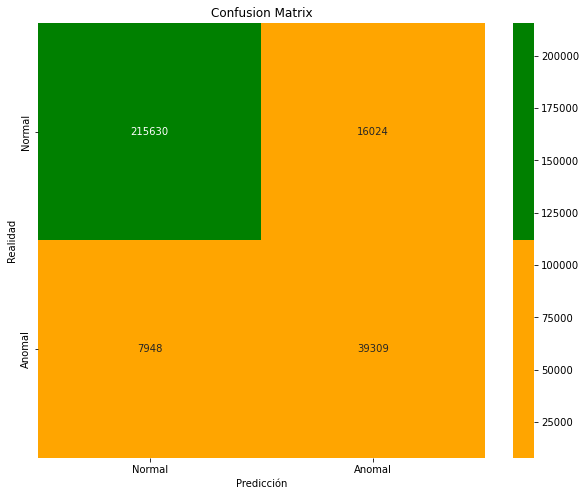

In [26]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_LSTM[:,14])

In [27]:
test_timedelta.reset_index(inplace=True)

In [28]:
predictions_class_LSTM_pd = pd.concat([test_timedelta, predictions_class_LSTM_pd], axis = 1 , join = "inner")

In [29]:
anomalies_LSTM = predictions_class_LSTM_pd.loc[predictions_class_LSTM_pd['class'] == 1.0,['timedelta']]

In [31]:
anomalies_LSTM

,timedelta
2,0 days 00:11:00
6,0 days 00:41:00
11,0 days 01:18:00
19,0 days 02:12:00
24,0 days 03:01:00
...,...
278898,1200 days 22:23:00
278904,1200 days 23:07:00
278905,1200 days 23:21:00
278906,1200 days 23:39:00


### RBM

Creación del modelo

In [32]:
model_rbm = Sequential()
model_rbm.add(Dense(20, input_shape=(train_data.shape[1],), activation='sigmoid'))
model_rbm.add(Dense(train_data.shape[1], activation='sigmoid'))
model_rbm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

Entreno el modelo Restricted Boltzmann Machine

In [33]:
model_rbm.fit(train_data, train_data, epochs=20, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/20
31378/31378 [==============================] - 36s 1ms/step - loss: 0.5774 - val_loss: 0.5755
Epoch 2/20
31378/31378 [==============================] - 61s 2ms/step - loss: 0.5742 - val_loss: 0.5751
Epoch 3/20
31378/31378 [==============================] - 28s 888us/step - loss: 0.5740 - val_loss: 0.5750
Epoch 4/20
31378/31378 [==============================] - 28s 896us/step - loss: 0.5738 - val_loss: 0.5748
Epoch 5/20
31378/31378 [==============================] - 29s 912us/step - loss: 0.5738 - val_loss: 0.5749
Epoch 6/20
31378/31378 [==============================] - 35s 1ms/step - loss: 0.5738 - val_loss: 0.5747
Epoch 7/20
31378/31378 [==============================] - 32s 1ms/step - loss: 0.5736 - val_loss: 0.5749
Epoch 8/20
31378/31378 [==============================] - 33s 1ms/step - loss: 0.5736 - val_loss: 0.5746
Epoch 9/20
31378/31378 [==============================] - 32s 1ms/step - loss: 0.5735 - val_loss: 0.5745
Epoch 10/20
31378/31378 [========================

In [34]:
predictions_rbm = model_rbm.predict(test_data)

8716/8716 [==============================] - 5s 572us/step


Evaluación del modelo rbm

In [35]:
threshold_rbm = 0.05
predictions_rbm[predictions_rbm >= threshold_rbm] = 1
predictions_rbm[predictions_rbm < threshold_rbm] = 0

In [36]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_rbm[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0    1.0
Actual                  
0.0        219064  12590
1.0          8375  38882


In [37]:
pd_predictions = pd.DataFrame(predictions_rbm)
column_10_rbm = predictions_rbm[:, 10]
is_one_rbm = column_10_rbm ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_rbm = np.where(is_one_rbm, 1, 0)

In [38]:
has_ones_rbm_pd = pd.DataFrame(has_ones_rbm, columns=['class'])
count = (has_ones_rbm_pd['class'] == 1).sum()
count1 = (has_ones_rbm_pd['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} son valores normales')

El número de anomalias predecidas es 51472 y 227439 son valores normales


In [39]:
new_column_rbm = has_ones_rbm
new_column_rbm.shape

(278911,)

In [40]:
predictions_class_rbm = np.hstack((predictions_rbm, new_column_rbm.reshape(-1, 1)))

In [41]:
pd_predictions_rbm = pd.DataFrame(predictions_class_rbm)

In [42]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_rbm[:,14], y))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    227439
         1.0       0.82      0.76      0.79     51472

    accuracy                           0.92    278911
   macro avg       0.88      0.86      0.87    278911
weighted avg       0.92      0.92      0.92    278911



In [43]:
predictions_class_rbm_pd  = pd.DataFrame(predictions_class_rbm, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_rbm_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 51472


In [44]:
predictions_class_rbm

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

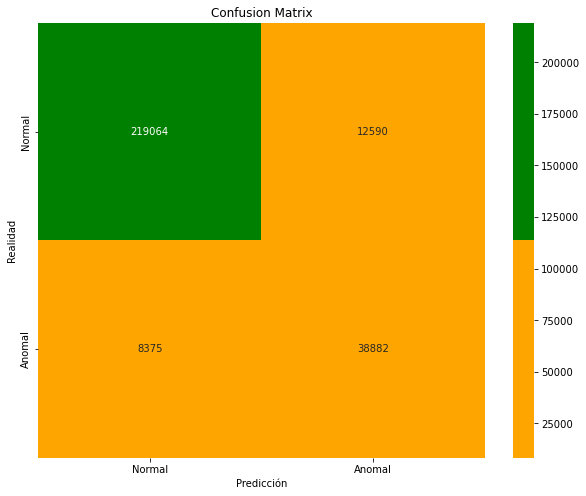

In [46]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_rbm[:,14])

In [47]:
predictions_class_rbm_pd = pd.concat([test_timedelta, predictions_class_rbm_pd], axis = 1 , join = "inner")

In [62]:
anomalies_rbm = predictions_class_rbm_pd.loc[predictions_class_rbm_pd['class'] == 1.0,['timedelta']]

In [63]:
anomalies_rbm

,timedelta
2,0 days 00:11:00
6,0 days 00:41:00
11,0 days 01:18:00
19,0 days 02:12:00
24,0 days 03:01:00
...,...
278898,1200 days 22:23:00
278904,1200 days 23:07:00
278905,1200 days 23:21:00
278906,1200 days 23:39:00


### Isolation Forest

Creación del modelo

In [50]:
model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=0)

Entreno el modelo

In [51]:
model_if.fit(train_data,train_data)

IsolationForest(random_state=0)

In [52]:
predictions_if = model_if.predict(test_data)

Evaluación del modelo Isolation Forest

In [53]:
threshold_if = 0.05
predictions_if[predictions_if >= threshold_if] = 1
predictions_if[predictions_if < threshold_if] = 0

In [54]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_if, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted      0       1
Actual                  
0.0        20351  211303
1.0        10298   36959


In [55]:
pd_predictions_if = pd.DataFrame(predictions_if, columns=['class'])
count = (pd_predictions_if['class'] == 1).sum()
count1 = (pd_predictions_if['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 248262 y 30649 valores normales


In [56]:
print(classification_report(pd_predictions_if, y))

              precision    recall  f1-score   support

           0       0.09      0.66      0.16     30649
           1       0.78      0.15      0.25    248262

    accuracy                           0.21    278911
   macro avg       0.43      0.41      0.20    278911
weighted avg       0.71      0.21      0.24    278911



In [57]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47257


In [58]:
count = (pd_predictions_if['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 248262


In [59]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

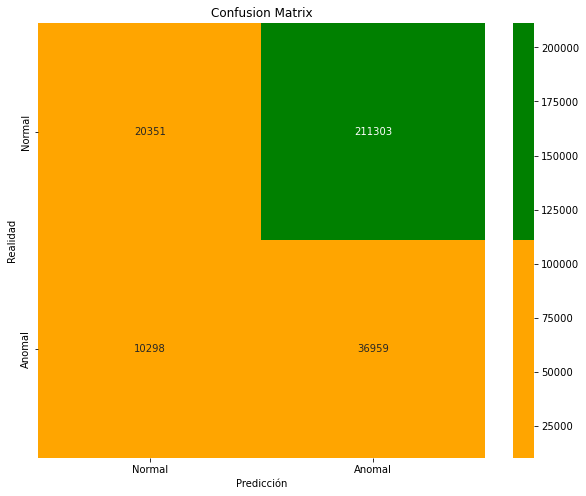

In [60]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_if)

In [61]:
predictions_class_if_pd = pd.concat([test_timedelta, pd_predictions_if], axis = 1 , join = "inner")

In [66]:
predictions_class_if_pd

,index,timedelta,class
0,3,0 days 00:03:00,1
1,4,0 days 00:04:00,1
2,11,0 days 00:11:00,1
3,16,0 days 00:16:00,1
4,27,0 days 00:27:00,1
...,...,...,...
278906,1729419,1200 days 23:39:00,1
278907,1729427,1200 days 23:47:00,1
278908,1729429,1200 days 23:49:00,1
278909,1729434,1200 days 23:54:00,1


In [70]:
anomalies_if = predictions_class_if_pd.loc[predictions_class_if_pd['class'] == 1.0,['timedelta']]

In [71]:
anomalies_if

,timedelta
0,0 days 00:03:00
1,0 days 00:04:00
2,0 days 00:11:00
3,0 days 00:16:00
4,0 days 00:27:00
...,...
278906,1200 days 23:39:00
278907,1200 days 23:47:00
278908,1200 days 23:49:00
278909,1200 days 23:54:00


### Support Vector Machines

Creación del modelo

In [69]:
model_svm = OneClassSVM(kernel='rbf', nu=0.01)

Entreno el modelo

In [72]:
model_svm.fit(train_data)

OneClassSVM(nu=0.01)

In [73]:
predictions_svm = model_svm.predict(test_data)

Evaluación del Modelo Support Vector Machines

In [74]:
predictions_svm[predictions_svm == 1] = 0
predictions_svm[predictions_svm == -1] = 1

In [75]:
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_svm, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted       0     1
Actual                 
0.0        229637  2017
1.0         46353   904


In [76]:
pd_predictions_svm = pd.DataFrame(predictions_svm, columns=['class'])
count = (pd_predictions_svm['class'] == 1).sum()
count1 = (pd_predictions_svm['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 2921 y 275990 valores normales


In [77]:
print(classification_report(pd_predictions_svm, y))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    275990
           1       0.02      0.31      0.04      2921

    accuracy                           0.83    278911
   macro avg       0.51      0.57      0.47    278911
weighted avg       0.98      0.83      0.90    278911



In [78]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47257


In [79]:
count = (pd_predictions_svm['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 2921


In [80]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

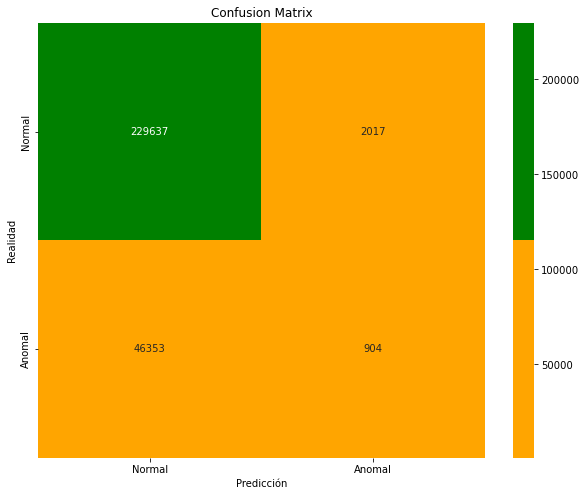

In [81]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_svm)

In [146]:
anomalies_svm = pd.concat([test_timedelta, pd_predictions_svm], axis = 1 , join = "inner")

In [147]:
anomalies_svm

,index,timedelta,index,timedelta,class
0,3,0 days 00:03:00,3,0 days 00:03:00,0
1,4,0 days 00:04:00,4,0 days 00:04:00,0
2,11,0 days 00:11:00,11,0 days 00:11:00,0
3,16,0 days 00:16:00,16,0 days 00:16:00,0
4,27,0 days 00:27:00,27,0 days 00:27:00,0
...,...,...,...,...,...
278906,1729419,1200 days 23:39:00,1729419,1200 days 23:39:00,0
278907,1729427,1200 days 23:47:00,1729427,1200 days 23:47:00,0
278908,1729429,1200 days 23:49:00,1729429,1200 days 23:49:00,0
278909,1729434,1200 days 23:54:00,1729434,1200 days 23:54:00,0


## Gráficos y evaluación con AUC

In [82]:
clase = y_full[:,-1].astype(int)

In [83]:
from sklearn.metrics import roc_auc_score

# Calcular el AUC para cada modelo utilizando la función roc_auc_score() de la biblioteca scikit-learn
LSTM_auc = roc_auc_score(clase, predictions_class_LSTM[:,14])
rbm_auc = roc_auc_score(clase, predictions_class_rbm[:,14])
if_auc = roc_auc_score(clase, predictions_if)
svm_auc = roc_auc_score(clase, predictions_svm)
print("AUC de LSTM Autoencoder:", LSTM_auc)
print("AUC de Restricted Bolztmann Machine:", rbm_auc)
print("AUC de Isolation Forest:", if_auc)
print("AUC de Suport Vector Machines:", svm_auc)

AUC de LSTM Autoencoder: 0.8813205744715598
AUC de Restricted Bolztmann Machine: 0.8842146413112433
AUC de Isolation Forest: 0.434968020124509
AUC de Suport Vector Machines: 0.5052112451286748


In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [85]:
rbm_fpr, rbm_tpr, _ = roc_curve(clase, predictions_class_rbm[:,14])
rbm_auc = auc(rbm_fpr, rbm_tpr)

In [86]:
LSTM_fpr, LSTM_tpr, _ = roc_curve(clase, predictions_class_LSTM[:,14])
LSTM_auc = auc(LSTM_fpr, LSTM_tpr)

In [87]:
if_fpr, if_tpr, _ = roc_curve(clase, predictions_if)
if_auc = auc(if_fpr, if_tpr)

In [88]:
svm_fpr, svm_tpr, _ = roc_curve(clase, predictions_svm)
svm_auc = auc(svm_fpr, svm_tpr)

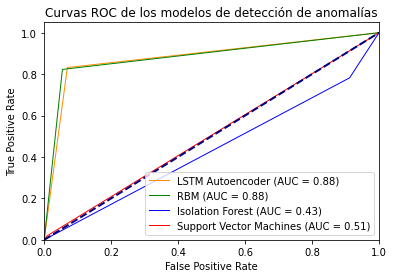

In [89]:
plt.figure()
plt.plot(LSTM_fpr, LSTM_tpr, color='darkorange', lw=1, label='LSTM Autoencoder (AUC = %0.2f)' % LSTM_auc)
plt.plot(rbm_fpr, rbm_tpr, color='green', lw=1, label='RBM (AUC = %0.2f)' % rbm_auc)
plt.plot(if_fpr, if_tpr, color='blue', lw=1, label='Isolation Forest (AUC = %0.2f)' % if_auc)
plt.plot(svm_fpr, svm_tpr, color='red', lw=1, label='Support Vector Machines (AUC = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los modelos de detección de anomalías')
plt.legend(loc="lower right")
plt.show()

## Reporte en PDF

In [155]:
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Table, TableStyle

pdf = canvas.Canvas("Reporte de Anomalías.pdf", pagesize=A4)
page_width, page_height = A4
inch = 72
df = anomalies_rbm

data = [df.columns.tolist()] + df.values.tolist()

styles = getSampleStyleSheet()
style_table = TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
    ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
    ('FONTSIZE', (0, 1), (-1, -1), 12),
    ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
])

num_rows = len(data)
num_cols = len(data[0])

max_rows_per_page = int((page_height - 5.5 * inch) / (12 * 1.2)) - 1

num_pages = int(num_rows / max_rows_per_page) + 1

for page in range(num_pages):
    # Título en la primera página
    if page == 0:
        pdf.setFont("Helvetica-Bold", 16)
        pdf.drawString(inch, page_height - inch, "Reporte de anomalías detectadas")
        pdf.drawString(inch, page_height - inch+18, "INVAP")

    # Pie de página en todas las páginas
    pdf.setFont("Helvetica", 8)
    pdf.drawString(inch, inch+12, "Especialización en Inteligencia Artificial")
    pdf.drawString(inch, inch, "Ing. Raúl Blanco Elicabe")

    start_row = page * max_rows_per_page
    end_row = min((page + 1) * max_rows_per_page, num_rows)

    page_data = data[start_row:end_row]

    table = Table(page_data, colWidths=[1.5 * inch] * num_cols)
    table.setStyle(style_table)

    table.wrapOn(pdf, page_width - 2 * inch, page_height - 2 * inch)
    table.drawOn(pdf, inch, page_height - 10 * inch - 12 * 1.2)

    if page < num_pages - 1:
        pdf.showPage()

pdf.save()
